In [1]:
import helpers
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import bz2
import json

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Review of sentiment analysis

The classic gold standard lexicon, especially for longer text, is LIWC (Linguistic Inquiry and Word Count). It is a Semantic Orientation (Polarity-based) Lexicon. Sociologists, psychologists, linguists, and computer scientists find LIWC appealing because it has been extensively validated. Also, its straightforward dictionary and simple word lists are easily inspected, understood, and extended if desired. Such attributes make LIWC an attractive option to researchers looking for a reliable lexicon to extract emotional or sentiment polarity from text. Despite their pervasive use for gaging sentiment in social media contexts, these lexicons are often used with little regard for their actual suitability to the domain. 

But LIWC is unable to account for differences in the sentiment intensity of words. For example, “The food here is exceptional” conveys morepositive intensity than “The food here is okay”. A sentiment analysis tool using LIWC would score them equally(they each contain one positive term). Such distinctions are intuitively valuable for fine-grained sentiment analysis and in our case to detect true polarization. "I am skeptic about climate" is not as intense as "I hate Greta Thunberg".


#NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

#Since VADER is pretrained, you can get results more quickly than with many other analyzers.
#  However, VADER is best suited for language used in social media, like short sentences with some slang and abbreviations.
# It’s less accurate when rating longer, structured sentences, but it’s often a good launching point.


Given the length of our quotes and after assessing the ease of use of different sentiment analysis methods, we have decided to use VADER[^fn1] (Valence Aware Dictionary for sEntiment Reasoning)

In the paper describing, we see that VADER (F1 = 0.96) actually even outperforms individual human raters (F1 = 0.84) at correctly classifying the sentiment of tweets into positive, neutral, or negative classes.

VADER is the result of very thorough work. It accesses its own lexicon but also uses other valence based lexicons to complete its training.

SenticNet is a publicly available semantic and affective resource for concept-level opinion and sentiment analysis (Cambria, Havasi, & Hussain, 2012). SenticNet is constructed by means of sentic computing, a paradigm that exploits both AI and Semantic Web techniques to process natural language opinions via an ensemble of graph-mining and dimensionality-reduction techniques (Cambria, Speer, Havasi, & Hussain, 2010). The SenticNet lexicon consists of 14,244 common sense concepts such as wrath, adoration, woe, and admiration with information associated with (among other things) the concept’s sentiment polarity, a numeric value on a continuous scale ranging from –1 to 1. VADER accesses the SenticNet polarity score using the online SenticNet API and a publicly available Python package.

SentiWordNet is an extension of WordNet (Fellbaum, 1998) in which 147,306 synsets are annotated with three numerical scores relating to positivity, negativity, and objectivity (neutrality) (Baccianella, Esuli, & Sebastiani, 2010). Each score ranges from 0.0 to 1.0, and their sum is1.0 for each synset. The scores were calculated using a complex mix of semi-supervised algorithms (propagationmethods and classifiers). It is thus not a gold standard resource like WordNet, LIWC, GI, or ANEW (which were all 100% curated by humans), but it is useful for a wide range of tasks. VADER interfaces with SentiWordNet via Python’s Natural Language Toolkit (NLTK), and use the difference of each sysnset’s positive and negative scores as its sentiment valence to distinguish differences in the sentiment intensity of words.The SentiWordNet lexicon is very noisy; a large majority of synsets have no positive or negative polarity. It also fails to account for sentiment bearing lexical features relevant to text in microblogs.

ANEW words have an associated sentiment valence ranging from 1-9 (with a neutral midpoint at five), such that words with valence scores less than five are considered unpleasant/negative, and those
with scores greater than five are considered pleasant/positive. 

We also went through the ADA lectures on text analysis and remarked that VADER was also used, further convincing us that it is indeed a quality choice.


SCORING:

 The 'compound' score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1 or close to it with float operation).  These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.


For longer text:

Use LIWC (Linguistic Inquiry and Word Count), it is Semantic Orientation (Polarity-based) Lexicons, thus it is not capable of differentating "exceptional" from "good".

[^fn1]: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [7]:
# Following this tutorial: https://realpython.com/python-nltk-sentiment-analysis/#:~:text=Sentiment%20analysis%20is%20the%20practice,obtain%20insights%20from%20linguistic%20data.






[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_pickle("df2017_0")

In [3]:
def analyze_sentiment(text):
    polarity_scores = sia.polarity_scores(text)
    print(f"Portion of the text which is negative: {polarity_scores['neg']}.")
    print(f"Portion of the text which is neutral: {polarity_scores['neu']}.")
    print(f"Portion of the text which is positive: {polarity_scores['pos']}.")

    print(f"Normalized weighted average composite score i.e. normalized sum of the valence scores of each word in the lexicon: {polarity_scores['compound']}\n")

In [6]:
def plot_sentiment_hist(df,sentiment='compound',all=False):

    if all:
        f,a = plt.subplots(2,2,figsize=(15,7),sharey=True)
        sentiments = ['neg','neu','pos','compound']
        transformed = df.quotation.apply(lambda x : sia.polarity_scores(x))
        f.suptitle("Distribution of 'neg', 'neu', 'pos' and 'compound' in the given corpus")

        for i, sent in enumerate(sentiments):
            idx = divmod(i,2)
            g = sns.histplot(data=transformed.apply(lambda x: x[sent]), bins='auto',ax=a[idx[0],idx[1]])
            g.set_xlabel(f"{sent} score")
            g.set_yscale('log')
    else:

        transformed = df.quotation.apply(lambda x : sia.polarity_scores(x)[sentiment])
        f, a = plt.subplots(figsize=(15, 5))
        f.suptitle(f"Distribution of {sentiment} sentiment")
        g= sns.histplot(data=test,bins='auto')
        g.set_xlabel(f"{sentiment} score")
        g.set_yscale('log')

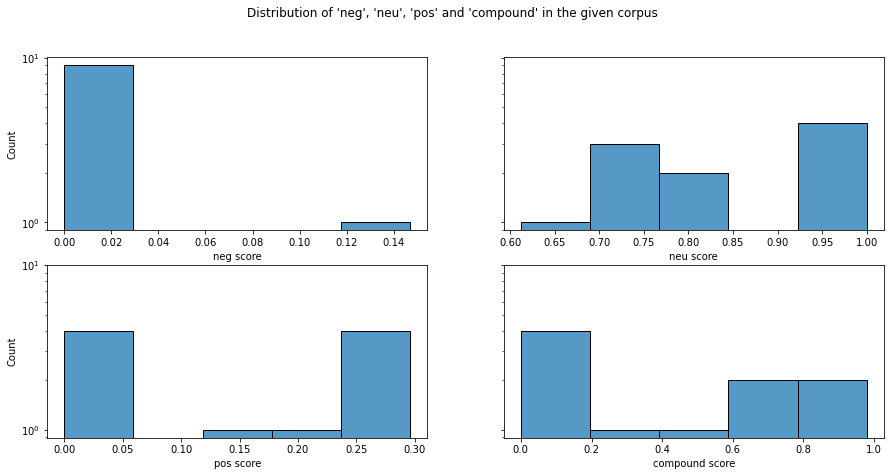

In [7]:
plot_sentiment_hist(df[0:10],sentiment='pos', all=True)